# <span style="color:red">Important</span>

Go to section 2 for the function that retrieves the distribution.

Go to section 3 if you just want to upload the data ready to go.

# 1. ETL



5k as the only data source. You can download the data [here](http://www.ub.edu/cvub/recipes5k/).

## 1.1 Uploading data train_images.txt, recepies and indexes

In [2]:
import pandas as pd

# Importing training images ID
file_path = "5k/Recipes5k/annotations/train_images.txt"
trained_images = pd.read_csv(file_path, sep="\t", names=["id_image"])
print(f"N elements in training: {trained_images.shape[0]}")

# Importing labels
file_path = "5k/Recipes5k/annotations/train_labels.txt"
trained_labels = pd.read_csv(file_path, sep="\t", names=["index_recepies"])

print(f"N elements in labels: {trained_labels.shape[0]}")

# importing recepies
file_path = "5k/Recipes5k/annotations/ingredients_simplified_Recipes5k.txt"
ingredients_index = pd.read_csv(file_path, sep="\t", names=["index_ingredients"])

print(f"N ingredients in indices in index: {ingredients_index.shape[0]}")

i = 34

print(trained_images.iloc[i])
print(trained_labels.iloc[i])

ingredients_index.iloc[trained_labels.iloc[i]]["index_ingredients"]

N elements in training: 3409
N elements in labels: 3409
N ingredients in indices in index: 4826
id_image    apple_pie/38_apple_pie_for_one_hostedLargeUrl.jpg
Name: 34, dtype: object
index_recepies    87
Name: 34, dtype: int64


87    apple,sugar,cinnamon,lemon,flour,salt,butter,i...
Name: index_ingredients, dtype: object

In [3]:
# Splitting the names in label, name, key and separating

trained_images["label"] = trained_labels["index_recepies"]
trained_images["image_name"] = [i.split("/")[1] for i in trained_images["id_image"]]
trained_images["key_value"] = [i.split("/")[0] for i in trained_images["id_image"]]
trained_images["ingredients"] = [
    ingredients_index.iloc[i]["index_ingredients"] for i in trained_images["label"]
]

# Open AI prompt engineering for recepies

In [5]:
import os
import dotenv
from langchain_core.prompts import PromptTemplate
from langchain import LLMChain
from langchain_openai import OpenAI


template = """I'll pass you a key representation name of a dish\
    and a list of ingredients such as:\
    key representation: apple_pie\
    list of ingredients:sugar,nutmeg,milk,butter,flour,pastry,cinnamon,apples,lemon\
    and you have to return a json as follow:\
    {{"{key}": {{"sugar": 150,"nutmeg": 0.50,"milk": 240,"butter": 113,"flour": 180,\
    "pastry": 1, "cinnamon": 2.60,"apples": 680,"lemon": 15}}}}\
    where each ingredient is listed with its corresponding quantity in grams.\
    Now do it but with:\
    key representation: {key}\
    list of ingredients: {ingredients}
"""

## Using OpenAI to bring the recepies in grams

Checking how much it will cost knowing that is 6 dollar per 1M tokens

In [18]:
# from langchain.callbacks import get_openai_callback

# for _, row in trained_images.iterrows():

#     with get_openai_callback() as cb:
#         # Your code here, for example:
#         prompt = PromptTemplate(input_variables=["key", "ingredients"], template=template)
#         llm_gpt3_5_chain = LLMChain(prompt=prompt, llm=OpenAI())
#         response = llm_gpt3_5_chain.run(
#             key=row["key_value"],
#             ingredients=row["ingredients"],
#             temperature=0,
#         )


#     total_tokens = cb.total_tokens
#     print(f"Total tokens used: {total_tokens}")
#     break

Total tokens used: 243


### Getting the right format and grams using OpenAI

In [101]:
# import json

# recepies_grams = []
# counter = 1

# for _, row in trained_images.iterrows():

#     prompt = PromptTemplate(input_variables=["key", "ingredients"], template=template)
#     llm_gpt3_5_chain = LLMChain(prompt=prompt, llm=OpenAI())

#     input_params = {
#         "key": row["key_value"],
#         "ingredients": row["ingredients"],
#         "temperature": 0,
#     }
#     response = llm_gpt3_5_chain.invoke(input_params)
#     recepies_grams.append(response["text"])

#     counter += 1
#     if counter % 50 == 0:
#         print(f"Number: {counter}")

# trained_images['json_format']=recepies_grams
# trained_images.to_csv('FINAL_DATA.csv',index=False)

## 1.2 Read the data with the OpenAI retrievals

In [102]:
data = pd.read_csv("FINAL_DATA.csv")

In [106]:
data["json_format"] = [
    i.replace("\n\n", ",").replace("\n", "") for i in data["json_format"]
]

In [168]:
import json
import ast

as_dic = []
counter = 0
indexes = []

for i, row in data.iterrows():
    string = row["json_format"]
    try:
        data_list = ast.literal_eval(string)

        if len(data_list) == 1:
            result = json.loads(string)
            as_dic.append(result)

        elif len(data_list) >= 2:
            result = dict([list(ast.literal_eval(string).items())[1]])
            as_dic.append(result)

    except:
        indexes.append(i)

In [175]:
### How many data had trouble with the API:

len(indexes)

194

In [174]:
# How is the distributiono data with problems:

data[["key_value", "label"]].iloc[indexes].groupby(
    "key_value", as_index=False
).count().sort_values("label", ascending=False)

,key_value,label
59,scallops,14
61,shrimp_and_grits,11
25,eggs_benedict,10
21,croque_madame,8
60,seaweed_salad,8
...,...,...
28,filet_mignon,1
37,hamburger,1
36,gyoza,1
31,french_onion_soup,1


In [176]:
data = data.drop(indexes)

In [177]:
data["json_format_clean"] = as_dic

In [193]:
def sum_nested_dict_values(nested_dict):
    total_sum = 0
    for inner_dict in nested_dict.values():
        total_sum += sum(inner_dict.values())
    return total_sum


indexes = []
total_g = []

for i, row in data.iterrows():
    dic_to_transform = row["json_format_clean"]
    try:
        total_g.append(sum_nested_dict_values(dic_to_transform))
    except:
        indexes.append(i)

In [194]:
data = data.drop(indexes)
data["total_g"] = total_g

In [196]:
for i, row in data[["json_format_clean", "total_g"]].sample(2).iterrows():
    print(row["json_format_clean"])
    print(row["total_g"])

{'prime_rib': {'rib': 1000, 'herbes de provence': 5, 'salt': 5, 'pepper': 5}}
1015.0
{'huevos_rancheros': {'corn tortillas': 120, 'beans': 200, 'vegetables': 150, 'salsa': 100, 'lime': 25, 'oil': 15, 'egg': 2, 'cilantro': 5, 'pepper': 5}}
622.0


# 2. Getting the proportions of fat, carbs and protein

In this section we are creating the nutritient proportions using 5k.

## VectorDatabase

As some ingredients are not in out nutrition dataframe we assing the closest based on similarity embeddings. If the query is empty, zero distribution of nutrients are assigned. For example, this happen with *cold water*.

In [198]:
import chromadb

chroma_client = chromadb.Client()

# Create or load a collection
collection_name = "mycollection"

# Get all collections
collections = chroma_client.list_collections()

# Extract names from collection objects
collection_names = [collection.name for collection in collections]

# Check if the collection exists
if collection_name in collection_names:
    # Load the existing collection
    collection = chroma_client.get_collection(collection_name)
    print("Loaded existing collection:", collection_name)
else:
    # Create a new collection and add data to it
    collection = chroma_client.create_collection(name=collection_name)
    print("Created new collection:", collection_name)

Created new collection: mycollection


In [199]:
from sentence_transformers import SentenceTransformer

# Read the ingredients:
file_path = "nutrition5k_dataset_metadata_ingredients_metadata.csv"
nutrition = pd.read_csv(
    file_path,
)

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embedding_list = model.encode(list(nutrition["ingr"]))

/Users/rafaeldavila/Documents/Duke/Sem2/ML/final/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [202]:
# How json cleaned look like
data["json_format_clean"][0]

{'apple_pie': {'flour': 180,
  'salt': 1,
  'oil': 120,
  'cold water': 240,
  'apple': 680,
  'sugar': 150,
  'cinnamon': 2.6,
  'butter': 113}}

In [200]:
# How nutrition dataframe look like
nutrition.sample(4)

,ingr,id,cal/g,fat(g),carb(g),protein(g)
199,buttermilk,200,0.402,0.009,0.048,0.033
541,white beans,542,1.390,0.004,0.251,0.097
357,mixed vegetables,358,0.320,0.003,0.069,0.017
193,fried rice,194,1.577,0.022,0.299,0.047


In [211]:
# Number of ingredients
nutrition.shape[0]

555

## Adding the nutrients into the vector database

In [79]:
collection.add(
    embeddings=embedding_list,
    documents=list(nutrition["ingr"]),
    ids=["ID" + str(i) for i in range(len(embedding_list))],
)

For example, "back ribs" is not in our ingredients, however only ribs it is, so it is assigned instead from the query to the vectordatabase.

In [347]:
"back ribs" in set(nutrition["ingr"])

False

In [207]:
label = list(data["json_format_clean"][0].keys())[0]
ingredients = list(data["json_format_clean"][0][label].keys())

['flour', 'salt', 'oil', 'cold water', 'apple', 'sugar', 'cinnamon', 'butter']

In [346]:
# Sample of nutrition loaded in the first section
nutrition.head(3)

,ingr,id,cal/g,fat(g),carb(g),protein(g)
0,cottage cheese,1,0.980,0.043,0.034,0.110
1,strawberries,2,0.330,0.003,0.080,0.007
2,garden salad,3,0.646,0.034,0.032,0.061


### This function return the distribution after the repepies are cleaned.

In [226]:
# Calories, fat, carb and protein


def get_calories_fat_carb_protein(dictionary_of_ingredients, nutrition, total_grams):
    """This function return the distribution of nutritional information in a 4D vector with fat,carbs, and protein.
    In addition, return the ingredients where the nutrition retrieval was unsuccesful, and the labels additioning the total calories per portion.


    Args:
        dictionary_of_ingredients (dict): The dictionary with ingredient of a single recepy
        nutrition (dataframe): The data frame with the nutrition distribution
        total_grams (_type_): The addition of grams by portion

    Returns:

        json: with the labels and names of nutrimental
        ingredients_not_found (list): list of ingredients not found in the VDB
        vector: a 4D list with the nutrimental distribution
    """

    ingredients_not_found = []

    label = list(dictionary_of_ingredients.keys())[0]

    ingredients = list(dictionary_of_ingredients[label].keys())

    # Initializing variables
    cal = 0
    fat = 0
    carb = 0
    protein = 0

    for ingredient in ingredients:

        ingr = ingredient

        if ingredient in set(nutrition["ingr"]):

            cal += (
                nutrition[nutrition["ingr"] == ingr]["cal/g"].iloc[0]
                * dictionary_of_ingredients[label][ingredient]
            )
            fat += (
                nutrition[nutrition["ingr"] == ingr]["fat(g)"].iloc[0]
                * dictionary_of_ingredients[label][ingredient]
            )
            carb += (
                nutrition[nutrition["ingr"] == ingr]["carb(g)"].iloc[0]
                * dictionary_of_ingredients[label][ingredient]
            )
            protein += (
                nutrition[nutrition["ingr"] == ingr]["protein(g)"].iloc[0]
                * dictionary_of_ingredients[label][ingredient]
            )
        else:

            # print(f"ingredient out of nutrition: {ingredient}")

            similar_documents = collection.query(query_texts=[ingredient], n_results=1)

            if len(similar_documents["documents"][0]) == 0:
                ingredients_not_found.append(ingr)

            else:
                ingr = similar_documents["documents"][0][0]

                cal += (
                    nutrition[nutrition["ingr"] == ingr]["cal/g"].iloc[0]
                    * dictionary_of_ingredients[label][ingredient]
                )
                fat += (
                    nutrition[nutrition["ingr"] == ingr]["fat(g)"].iloc[0]
                    * dictionary_of_ingredients[label][ingredient]
                )
                carb += (
                    nutrition[nutrition["ingr"] == ingr]["carb(g)"].iloc[0]
                    * dictionary_of_ingredients[label][ingredient]
                )
                protein += (
                    nutrition[nutrition["ingr"] == ingr]["protein(g)"].iloc[0]
                    * dictionary_of_ingredients[label][ingredient]
                )

    vector = [
        fat / total_grams,
        carb / total_grams,
        protein / total_grams,
        1 - (fat + carb + protein) / total_grams,
    ]

    return (
        {
            label: {
                "cal": cal,
                "fat": fat / total_grams,
                "carb": carb / total_grams,
                "protein": protein / total_grams,
                "other": 1 - (fat + carb + protein) / total_grams,
            }
        },
        ingredients_not_found,
        vector,
    )

({'apple_pie': {'cal': 3464.87,
   'fat': 0.14441678999058255,
   'carb': 0.25703820799138977,
   'protein': 0.014330687474774654,
   'other': 0.584214314543253}},
 ['cold water', 'cinnamon'],
 [0.14441678999058255,
  0.25703820799138977,
  0.014330687474774654,
  0.584214314543253])

In [229]:
list_distribution = []
list_jsons = []
list_not_found = []


for i, row in data.iterrows():

    j, n, v = get_calories_fat_carb_protein(
        dictionary_of_ingredients=row["json_format_clean"],
        nutrition=nutrition,
        total_grams=row["total_g"],
    )
    list_distribution.append(v)
    list_jsons.append(j)
    list_not_found.append(n)

/var/folders/qq/17cwmxhd3jv_w07w8pf57y5r0000gn/T/ipykernel_88136/152276334.py:69: RuntimeWarning: invalid value encountered in scalar divide
  vector=[fat/total_grams,carb/total_grams,protein/total_grams,1-(fat+carb+protein)/total_grams]
/var/folders/qq/17cwmxhd3jv_w07w8pf57y5r0000gn/T/ipykernel_88136/152276334.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return {label: {"cal": cal, "fat": fat/total_grams, "carb": carb/total_grams, "protein": protein/total_grams, "other":1-(fat+carb+protein)/total_grams}},ingredients_not_found,vector


In [232]:
data["target"] = list_distribution
data["json_nutrition"] = list_jsons
data["ing_not_found"] = list_not_found

# 3. Reading the DATA for Neural Network with Keras

In [27]:
import pandas as pd

# data.to_csv('FINAL_DATA_COMPLETE.csv',index=False)

data = pd.read_csv("FINAL_DATA_COMPLETE.csv")

In [28]:
import os

list_of_pics = os.listdir("5k/Recipes5k/images/SAMPLE/final_images")

In [29]:
list_of_pics = list(set(list_of_pics).intersection(set(data["image_name"])))
len(list_of_pics)

3211

In [30]:
data["target"][
    data["image_name"] == "34_honey_sriracha_chicken_wings_hostedLargeUrl.jpg"
]

900    [0.13564471669218992, 0.024791730474732005, 0....
Name: target, dtype: object

In [31]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization


image_directory = "5k/Recipes5k/images/SAMPLE/final_images"

In [68]:
SIZE = 200
X_dataset = []
for i in list_of_pics:
    img = image.load_img(
        "5k/Recipes5k/images/SAMPLE/final_images/" + i, target_size=(SIZE, SIZE, 3)
    )
    img = image.img_to_array(img)
    img = img / 255.0
    X_dataset.append(img)

X = np.array(X_dataset)

y = [data["target"][data["image_name"] == i].tolist()[0] for i in list_of_pics]

y = np.array(y)

In [49]:
# y was imported as string, and problems arose with [nan,...,nan]

import ast

counter = 0

for s in y:
    try:
        [float(i) for i in ast.literal_eval(s)]
        counter += 1
    except:
        print(s)
        print(counter)
        print(type(s))
        break

[nan, nan, nan, nan]
50
<class 'numpy.str_'>


In [58]:
y_transformed = np.array([np.fromstring(row[1:-1], sep=", ") for row in y])

In [59]:
# Check for NaNs or infinity in the array
nan_indices = np.isnan(y_transformed).any(axis=1)
inf_indices = np.isinf(y_transformed).any(axis=1)

# Get the indices where NaNs or infinity occur
indices_with_nan = np.where(nan_indices)[0]
indices_with_inf = np.where(inf_indices)[0]

if len(indices_with_nan) > 0:
    print("NaNs found at indices:", indices_with_nan)

if len(indices_with_inf) > 0:
    print("Infinity values found at indices:", indices_with_inf)

NaNs found at indices: [  50  333  512  640  641  660  756 1012 1220 1253 1530 1962 2251 2568
 2630 3181 3194]


In [69]:
# Dropping NANs

y = np.delete(y_transformed, indices_with_nan, axis=0)
X = np.delete(X, indices_with_nan, axis=0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=20, test_size=0.3
)

In [70]:
len(y)

3194

In [67]:
X_train.shape

(2235, 200, 200, 3)

## Keras Implementation

In [62]:
model = Sequential()

model.add(
    Conv2D(
        filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE, SIZE, 3)
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax"))

/Users/rafaeldavila/Documents/Duke/Sem2/ML/final/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 196, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 196, 196, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 43, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,412 (2.68 MB)

 Trainable params: 701,060 (2.67 MB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 2.0876 - mean_squared_error: 0.1046 - val_loss: 1.1750 - val_mean_squared_error: 0.0536
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.3567 - mean_squared_error: 0.0519 - val_loss: 1.1441 - val_mean_squared_error: 0.0490
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 1.1750 - mean_squared_error: 0.0400 - val_loss: 1.0961 - val_mean_squared_error: 0.0416
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 1.1339 - mean_squared_error: 0.0360 - val_loss: 1.0841 - val_mean_squared_error: 0.0390
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 1.0856 - mean_squared_error: 0.0308 - val_loss: 1.0141 - val_mean_squared_error: 0.0274
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 1.0524 - mean_squared_error: 0.0276 - val_loss: 0.9820 - val_mean_squared_error: 0.0219
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 1.0473 - mean_squared_error: 0.0284 - val_loss: 1.0253 - val_mean_

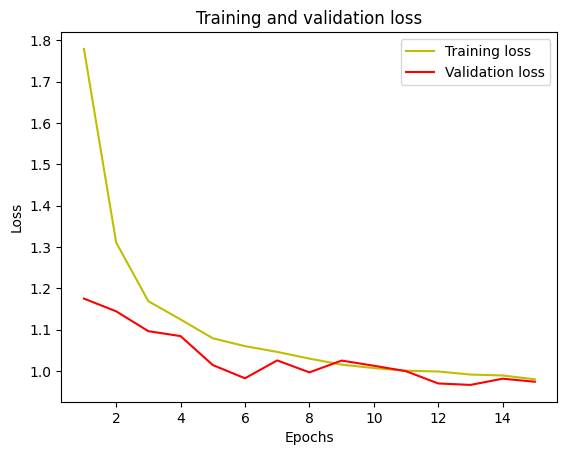

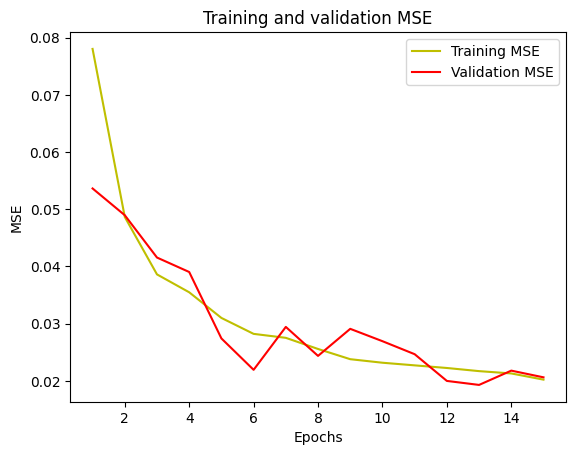

In [71]:
model.summary()

# Categorical was better suited for probabilities.
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["mean_squared_error"]
)


history = model.fit(
    X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=64
)


# plot the training and validation accuracy and loss at each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# acc = history.history["accuracy"]
mean_squared_error = history.history["mean_squared_error"]
# val_acc = history.history["val_accuracy"]
val_mean_squared_error = history.history["val_mean_squared_error"]
# plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, mean_squared_error, "y", label="Training MSE")
# plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.plot(epochs, val_mean_squared_error, "r", label="Validation MSE")
# plt.title("Training and validation Accuracy")
plt.title("Training and validation MSE")
plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [9]:
images_path = "5k/Recipes5k/images/SAMPLE/final_images/"
os.listdir(images_path)[:2]

['11_peanut_butter_frozen_yogurt_hostedLargeUrl.jpg',
 '31_french_onion_soup_hostedLargeUrl.jpg']

# Prediction

## Comparing the values with real values

In [76]:
# os.listdir('metadata')
test_data = pd.read_csv("metadata/dish_labels_5k_final.csv")
dishes_sample = test_data.sample(200)
dishes_sample = dishes_sample["dish"]
# Save dishes_sample to a .txt file
dishes_sample.to_csv("dishes_test.txt", index=False, header=False)

In [80]:
test_data.head(3)

,dish,cal,mass,fat_g,carb_g,prot_g,other_g,pct_fat,pct_carb,pct_prot,pct_other
0,dish_1561662216,300.794281,193,12.387489,28.218290,18.633970,133.760251,0.064184,0.146209,0.096549,0.693058
1,dish_1562688426,137.569992,88,8.256000,5.190000,10.297000,64.257000,0.093818,0.058977,0.117011,0.730193
2,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,215.899615,0.081638,0.090245,0.088735,0.739382


In [106]:
dishes_sample.reset_index(drop=True, inplace=True)
comparison_results = pd.DataFrame()
comparison_results["dish"] = os.listdir("dishes")

In [108]:
comparison_results["id"] = [i.split(".")[0] for i in comparison_results["dish"]]

In [109]:
comparison_results.head()

,dish,id
0,dish_1558382263.png,dish_1558382263
1,dish_1562873838.png,dish_1562873838
2,dish_1562605384.png,dish_1562605384
3,dish_1565813414.png,dish_1565813414
4,dish_1557861795.png,dish_1557861795


In [111]:
SIZE = 200
distributions = []

for sample_image in comparison_results["dish"]:
    img = image.load_img(
        f"dishes/{sample_image}",
        target_size=(SIZE, SIZE, 3),
    )

    img = image.img_to_array(img)
    img = img / 255.0
    # plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    proba = model.predict(img)
    distributions.append(proba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [112]:
comparison_results["distribution"] = distributions

In [115]:
comparison_results = comparison_results.merge(test_data, left_on="id", right_on="dish")

In [116]:
comparison_results.head(1)

,dish_x,id,distribution_x,dish_y,cal,mass,fat_g,carb_g,prot_g,other_g,pct_fat,pct_carb,pct_prot,pct_other,distribution_y
0,dish_1558382263.png,dish_1558382263,"[[0.15100457, 0.20095235, 0.10266991, 0.5453732]]",dish_1558382263,356.629974,425,19.562,23.453999,27.487001,354.497,0.046028,0.055186,0.064675,0.834111,"[0.046028235, 0.05518588, 0.064675296, 0.83411..."


In [117]:
comparison_results["diff"] = (
    comparison_results["distribution_x"] - comparison_results["distribution_y"]
)

In [134]:
[j[0][i] for j in comparison_results["diff"]]

[0.10497633274234772,
 0.09798731086882782,
 0.06901534684977723,
 0.08285072062511445,
 0.11097861611843109,
 0.09119569659365082,
 0.09371330386352539,
 0.0853401693620491,
 -0.3507187169790268,
 0.1375062232185974,
 0.04208587352183152,
 0.13636434483528137,
 0.13786773788928985,
 0.006555883883190158,
 0.07702067841362763,
 0.11909399247169494,
 0.12402655386924744,
 0.022779512554153447,
 0.12850076185411072,
 0.004226865860198978,
 0.07337827260530853,
 0.0718708129644394,
 0.04794810260031891,
 0.08348014353507996,
 0.1069393944914322,
 0.13056468840608978,
 0.05080585987289429,
 0.14865124189853668,
 0.07938733732700348,
 0.12037792867422104,
 0.14594238114356994,
 0.03408716465482331,
 -0.004801536301017761,
 0.12934455680847168,
 0.023841817378997807,
 0.07838200804138183,
 0.11617376087937165,
 0.13265065966939543,
 0.1253099969625473,
 0.028508327463424687,
 -0.28445841193199156,
 0.1278276074552536,
 0.04528663711474609,
 0.09100941034346771,
 0.11604211838655853,
 -0.0679

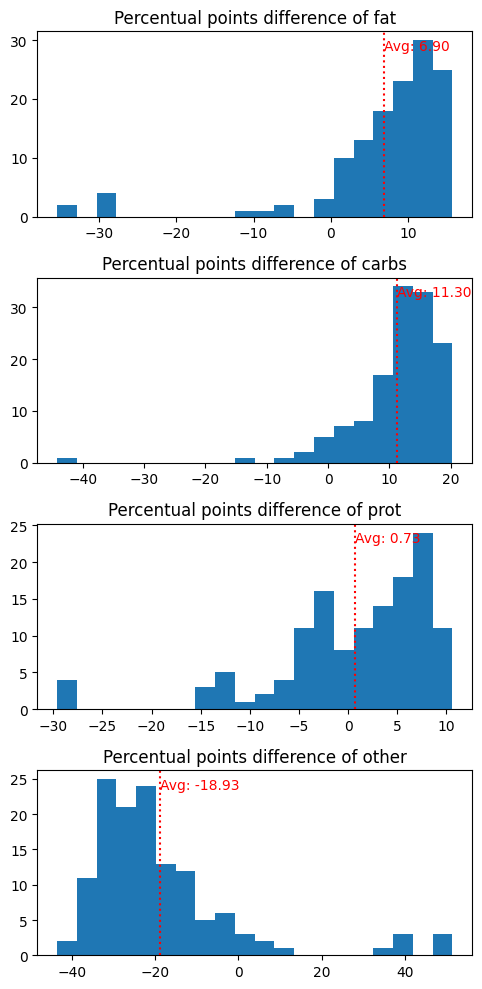

In [148]:
fig, ax = plt.subplots(4, 1, figsize=(5, 10))
names = ["fat", "carbs", "prot", "other"]
MAEs = []
avgs = []
sds = []
for i in range(4):
    temp_data = [100 * j[0][i] for j in comparison_results["diff"]]

    MAE = np.sum([abs(j) for j in temp_data]) / len(temp_data)

    MAEs.append(MAE)

    ax[i].hist(temp_data, bins=20)
    avg = np.mean(temp_data)
    avgs.append(avg)

    sd = np.std(temp_data)
    sds.append(sd)

    ax[i].axvline(avg, color="r", linestyle="dotted")
    ax[i].text(avg, ax[i].get_ylim()[1] * 0.9, f"Avg: {avg:.2f}", color="r")
    ax[i].set_title(f"Percentual points difference of {names[i]}")
plt.tight_layout()

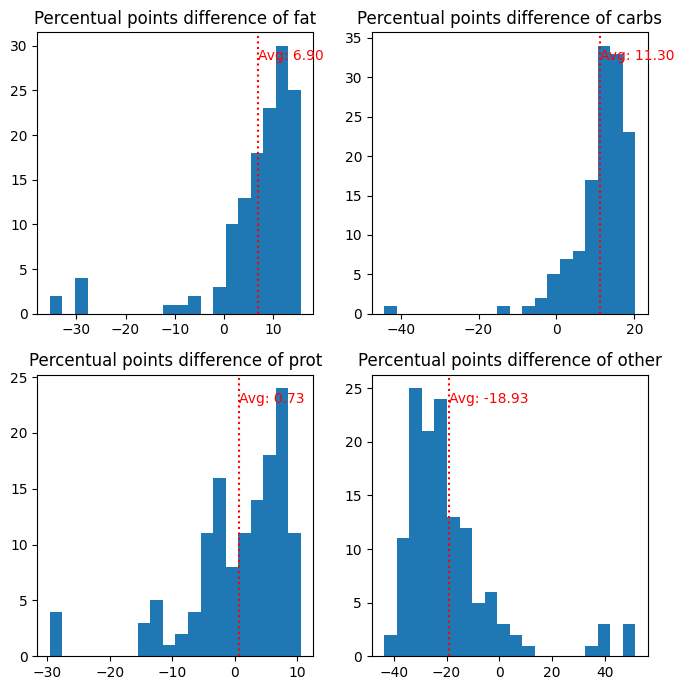

In [152]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
names = ["fat", "carbs", "prot", "other"]
MAEs = []
avgs = []
sds = []
for i in range(4):
    temp_data = [100 * j[0][i] for j in comparison_results["diff"]]

    MAE = np.sum([abs(j) for j in temp_data]) / len(temp_data)

    MAEs.append(MAE)

    ax[i // 2, i % 2].hist(temp_data, bins=20)
    avg = np.mean(temp_data)
    avgs.append(avg)

    sd = np.std(temp_data)
    sds.append(sd)

    ax[i // 2, i % 2].axvline(avg, color="r", linestyle="dotted")
    ax[i // 2, i % 2].text(
        avg, ax[i // 2, i % 2].get_ylim()[1] * 0.9, f"Avg: {avg:.2f}", color="r"
    )
    ax[i // 2, i % 2].set_title(f"Percentual points difference of {names[i]}")
plt.tight_layout()

In [154]:
data.head()

,id_image,label,image_name,key_value,ingredients,json_format,json_format_clean,total_g,target,json_nutrition,ing_not_found
0,apple_pie/20_homemade_apple_pie_hostedLargeUrl...,69,20_homemade_apple_pie_hostedLargeUrl.jpg,apple_pie,"flour,salt,oil,cold water,apple,sugar,cinnamon...","{""apple_pie"": {""flour"": 180, ""salt"": 1, ""oil"":...","{'apple_pie': {'flour': 180, 'salt': 1, 'oil':...",1486.6,"[0.14441678999058255, 0.25703820799138977, 0.0...","{'apple_pie': {'cal': 3464.87, 'fat': 0.144416...","['cold water', 'cinnamon']"
1,apple_pie/43_homestyle_apple_pie_hostedLargeUr...,91,43_homestyle_apple_pie_hostedLargeUrl.jpg,apple_pie,"shell,pie,sugar,flour,cinnamon,apple,lemon,but...","{""apple_pie"": {""shell"": 1, ""pie"": 1, ""sugar"": ...","{'apple_pie': {'shell': 1, 'pie': 1, 'sugar': ...",1382.6,"[0.07181759004773615, 0.28602849703457256, 0.0...","{'apple_pie': {'cal': 2527.94, 'fat': 0.071817...","['shell', 'pie', 'cinnamon']"
2,apple_pie/28_apple_pie_hostedLargeUrl.jpg,77,28_apple_pie_hostedLargeUrl.jpg,apple_pie,"apple,lemon,sugar,flour,cinnamon,nut,butter,sa...","{""apple_pie"": {""apple"": 680,""lemon"": 15,""sugar...","{'apple_pie': {'apple': 680, 'lemon': 15, 'sug...",1376.5,"[0.13531783508899384, 0.2786603705049038, 0.01...","{'apple_pie': {'cal': 3215.75, 'fat': 0.135317...","['cinnamon', 'nut', 'ice water']"
3,apple_pie/39_classic_apple_pie_hostedLargeUrl.jpg,88,39_classic_apple_pie_hostedLargeUrl.jpg,apple_pie,"pie,apple,sugar,corn starch,cinnamon,lemon,but...","{""apple_pie"": {""pie"": 1, ""apple"": 680, ""sugar""...","{'apple_pie': {'pie': 1, 'apple': 680, 'sugar'...",1097.6,"[0.08467793367346939, 0.23722029883381926, 0.0...","{'apple_pie': {'cal': 1807.16, 'fat': 0.084677...","['pie', 'cinnamon', 'egg', 'cold water']"
4,apple_pie/13_mug_apple_pie_hostedLargeUrl.jpg,62,13_mug_apple_pie_hostedLargeUrl.jpg,apple_pie,"apple,brown sugar,butter,cinnamon,allspice,nut...","{""apple_pie"": {""apple"": 680, ""brown sugar"": 15...","{'apple_pie': {'apple': 680, 'brown sugar': 15...",947.4,"[0.09804728731264514, 0.25576630778974035, 0.0...","{'apple_pie': {'cal': 1733.81, 'fat': 0.098047...","['cinnamon', 'allspice', 'nut', 'pie']"


In [161]:
data[data["key_value"] == "tiramisu"]["ingredients"]

1781    egg,egg,mascarpone,liqueur,sugar,espresso,lady...
1782    brewed espresso,coffee,mascarpone,sugar,ladyfi...
1783    sugar,water,espresso,amaretto,hazelnut,mascarp...
1784    egg,sugar,mascarpone,vanilla,coffee,espresso,s...
1785    lady fingers,espresso,mascarpone,egg,sugar,coc...
1786    caster sugar,sugar,egg,mascarpone,coffee,espre...
1787    egg,sugar,vanilla,mascarpone,lady fingers,kahl...
1788    lady fingers,liqueur,espresso,marsala wine,sug...
1789    egg,sugar,vanilla,marsala wine,egg,tartar,masc...
1790    egg,sugar,port,espresso,chocolate,mascarpone,l...
1791    water,sugar,espresso,whipping,vanilla,mascarpo...
1792          espresso,cookies,egg,sugar,mascarpone,cocoa
1793    egg,salt,sugar,mascarpone,ladyfingers,coffee,c...
1794    egg,sugar,mascarpone,egg,kirsch,coffee,ladyfin...
1795        egg,sugar,mascarpone,ladyfingers,coffee,cocoa
1796    egg,sugar,cheese,espresso,vermouth,savoiardi,c...
1797    egg,sugar,milk,vanilla,mascarpone,coffee,rum,c...
1798    egg,su